# ANLP Assignment: Sentiment Classification

In [1]:
candidateno=277248 #this MUST be updated to your candidate number so that you get a unique data sample


In [2]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [3]:
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.classify import NaiveBayesClassifier

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the
            pair is a list of the training data and the second is a list of the test data.
    """

    data = list(data)
    n = len(data)
    train_indices = random.sample(range(n), int(n * ratio))
    test_indices = list(set(range(n)) - set(train_indices))
    train = [data[i] for i in train_indices]
    test = [data[i] for i in test_indices]
    return (train, test)


def get_train_test_data():

    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')

    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]

    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [5]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['a', 'fully', 'loaded', 'entertainment', 'review', ...], 'pos')


#1) [20\%]

## Creating Positive and Negative Frequency Distributions

Below, we create positive and negative frequency distributions from our training set.

1.1) Counting how many non-alphabetical characters there are in the `training_data` set so that we can see what types of normalisation must be done on the data.


In [6]:
# checking to see what types of normalisation must be done on the data

num_char_count = 0

for (wordlist, label) in training_data:
  for item in wordlist:
    if item.isalpha() == False:
      num_char_count += 1

print(f"There are {num_char_count} non-alpha characters in the training_data set")

There are 177736 non-alpha characters in the training_data set


1.2) Creating the `normalise()` function, which normalises the words in a wordlist by making all words lowercase, filtering out punctuation, numbers, and any words that are in a list of English stopwords, and lemmatising all remaining words in the list.

We make all tokens lowercase so that words with different capitalization are counted as the same word. We filter stopwords because they tend to be the most common words a given corpus, and do not tell us much about the document itself. We filter out punctuation and numbers becasue they do not tell us much about a given document either. We lemmatize words so that words of the same lemma can be counted as a single word instead of multiple tokens which do not tell us more about the document.


In [7]:
# creating a normalise function that normalises the words in a wordlist

stop = stopwords.words('english')

def normalise(wordlist):
    lowered=[word.lower() for word in wordlist] #don't actually need this as already lowered
    filtered=[word for word in lowered if word.isalpha() and word not in stop]
    lemmd = [WordNetLemmatizer().lemmatize(word) for word in filtered]
    return lemmd

1.3) Creating `training_norm` and `testing_norm`: lists in which each item is a frequency distribution representing a document in `training_data` or `testing_data` respectively, paired with a label indicating if the document is positive or negative. To create these lists, we modify the `training_data` and `testing_data` lists by applying the `normalise()` and then the `FreqDist()` function to each wordlist in the dataset, while keeping the label for each unchanged.

We use frequency distributions because the wordlists are generated based on how often each word appears in the corpus for each class.

In [8]:
# creating frequency distributions for both datasets

training_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in training_data]
testing_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in testing_data]

training_norm[0]

(FreqDist({'cable': 8, 'guy': 8, 'steven': 7, 'carrey': 5, 'rather': 4, 'also': 3, 'critic': 3, 'like': 3, 'movie': 3, 'whole': 2, ...}),
 'pos')

1.4) Sorting the data in `training_norm` into a positive frequency distribution `pos_freq_dist` and a negative frequency distribution `neg_freq_dist`, which are frequency distributions of the words in all positive and negative documents in the training set respectively. To do this, we use a for loop to check if the label for each document is "pos". If it is, then the corresponding frequency distribution is added to `pos_freq_dist`. If the label is not "pos", we assume that the review is negative, as there are only two label options, and the corresponding frequency distribution is instead added to `neg_freq_dist`.

We can use these frequency distributions to create our representative wordlists.

In [9]:
# sorting the data in training_norm into
# a positive frequency distribution and a negative frequency distribution

pos_freq_dist=FreqDist()
neg_freq_dist=FreqDist()

for reviewDist,label in training_norm:
    if label=='pos':
        pos_freq_dist+=reviewDist
    else:
        neg_freq_dist+=reviewDist

print(pos_freq_dist)
print(neg_freq_dist)

<FreqDist with 22610 samples and 258322 outcomes>
<FreqDist with 20979 samples and 229218 outcomes>


## Using Frequency Distributions to Create Positive & Negative Wordlists

Below, we produce the positive and negative wordlists by passing `pos_freq_dist` and `neg_freq_dist` through the `most_frequent_words()` function.

1.5) Creating the `most_frequent_words()` function, which takes two frequency distributions and an integer $k$. The function orders words by how much more they occur in one frequency distribution than the other, which helps to provide us with words that are most representative of the reviews of a certain class in our data. It does this by subtracting one wordlist from the other and then uses the `most_common()` function to select the top $k$ words from the resulting difference list.

I choose to use the most frequent words method over the threshold method in this report because I understand it more intuitively.

In [10]:
def most_frequent_words(freq1,freq2,k):
    difference = freq1-freq2
    sorteddiff = difference.most_common()
    justwords = [word for (word,freq) in sorteddiff[:k]]
    return justwords

1.6) Generating `pos_wordlist10`, a wordlist of 10 content words which are representative of the positive reviews in our training data. We do this by passing (`pos_freq_dist`, `neg_freq_dist`) through the `most_frequent_words` function.

In [11]:
pos_wordlist10 = most_frequent_words(pos_freq_dist, neg_freq_dist, 10)
pos_wordlist10

['film',
 'life',
 'story',
 'also',
 'performance',
 'great',
 'well',
 'world',
 'best',
 'many']

1.7) Generating `neg_wordlist10`, a wordlist of 10 content words which are representative of the negative reviews in our training data. We do this by passing (`neg_freq_dist`, `pos_freq_dist`) through the `most_frequent_words` function.

In [12]:
neg_wordlist10 = most_frequent_words(neg_freq_dist, pos_freq_dist, 10)
neg_wordlist10

['movie',
 'bad',
 'plot',
 'even',
 'minute',
 'worst',
 'get',
 'boring',
 'big',
 'stupid']

#2) [12.5\%]

Below we have built a word list classifier, `SimpleClassifier()`, which classifies documents as being positive ("pos") or negative ("neg"). It inherits from the NLTK `ClassifierI` class, which means that all attributes and methods in the `ClassifierI` class are availalbe in the `SimpleClassifier()` class unless they are explicitly over-ridden.

2.1) Creating the `SimpleClassifier()` class:

- The initialisation method `__init__()` takes two arguments: `pos`, a predefined positive wordlist and `neg`, predefined negative wordlist.

- The classification method `classify()` takes one argument: `doc`, a frequency distribution of words from a document. This method uses for loops to check if each word in `doc` is in the positive or negative wordlists from the initialised classifer. If the word appears in `pos`, then the value listed in the frequency distribution for that word is added to `score`. If the word appears in `neg`, then the value listed in the frequency distribution is subtracted from `score`. If `score` at the end of the for loop is negative, then the document is classified as "neg". If it is positive, then the document is classified as "pos". If it is zero, then the document is randomly classified as either "pos" or "neg".

- The label retrieval method `labels()` gives the possible labels that the classifier can return.

In [13]:
class SimpleClassifier(ClassifierI):

    def __init__(self, pos, neg):
        self._pos = pos
        self._neg = neg

    def classify(self, doc):
        #doc is a FreqDist
        score = 0

        # add code here that assigns an appropriate value to score
        for word,value in doc.items():
            if word in self._pos:
                score+=value
            if word in self._neg:
                score-=value

        if score < 0:
          return "neg"
        elif score > 0:
          return "pos"
        else:
          return random.choice(["pos", "neg"])

    def labels(self):
        return ("pos", "neg")

2.4) Defining `classifier`, a classifier of the `SimpleClassifier()` class using the lists generated in Q1: `pos_wordlist10` and `neg_wordlist10`. This produces a word list classifier which will classify reviews as being positive or negative based on the given wordlists. We test this classifier with a sample sentence represented as a frequency distribution.

In [14]:
classifier = SimpleClassifier(pos_wordlist10, neg_wordlist10)
classifier.classify(FreqDist("The movie was bad".split()))

'neg'

#3) [20\%]

3.1) Calculating the accuracy of the classifier `classifier`.

In [15]:
def classifier_accuracy(cls, test_data):
    '''
    cls: an instance of a classifier object which has a classify method which returns "pos" or "neg"
    test_data: a list of pairs where each pair is a FreqDist rep of a doc and its label

    returns: float point number which is the accuracy of the classifier on the test data provided
    '''
    acc = 0
    docs,goldstandard = zip(*test_data)
    #pass all of the docs to the classifier and get back a list of predictions
    predictions=cls.classify_many(docs)
    #zip the predictions with the goldstandard labels and compare
    for prediction,goldlabel in zip(predictions,goldstandard):
        if prediction==goldlabel:
            acc+=1

    return acc / (len(test_data))

In [16]:
#Evaluate classifier
accuracy_wordlist = classifier_accuracy(classifier, testing_norm)
print(f"The accuracy of this classifier is {accuracy_wordlist}")

The accuracy of this classifier is 0.635


3.2) Calculating the precision, recall, and F1-Score of the classifier `classifier`, as well as other relevant figures.

In [17]:
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=("pos","neg")):

        (self.c1,self.c2)=classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1

            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1


    def precision(self):
        p = 0
        p = (self.TP)/(self.TP + self.FP)

        return p

    def recall(self):
        r=0
        r = (self.TP)/(self.TP + self.FN)

        return r

    def f1(self):
        f1=0
        p = self.precision()
        r = self.recall()

        f1 = (2*p*r)/(p+r)

        return f1

In [18]:
#docs will contain the documents to classify, labels contains the corresponding gold standard labels
docs,labels=zip(*testing_norm)
senti_cm=ConfusionMatrix(classifier.classify_many(docs),labels)
print("True positive score is {}".format(senti_cm.TP))
print("False positive score is {}".format(senti_cm.FP))
print("True negative score is {}".format(senti_cm.TN))
print("False negative score is {}".format(senti_cm.FN))
print("\n")
print("Precision is {}".format(senti_cm.precision()))
print("Recall is {}".format(senti_cm.recall()))
print("F1-Score is {}".format(senti_cm.f1()))

True positive score is 239
False positive score is 161
True negative score is 139
False negative score is 61


Precision is 0.5975
Recall is 0.7966666666666666
F1-Score is 0.6828571428571428


###Metrics for this classifier:

Accuracy $= 0.635$

Precision $= 0.5975 \approx 0.598$

Recall $= 0.7966666666666666 \approx 0.797$

F1-Score $= 0.6828571428571428 \approx 0.683$

### Evaluating Classifiers in terms of Accuracy:

In this case, it is reasonable to evaluate the classifier in terms of its accuracy. This is because the classes in our dataset are approximately balanced, meaning that the number of instances of each class in the dataset are approximately equal. Additionally, the quality and overall correctness of the classifier as suggested by its accuracy are in line with the quality of the classifier as suggested by its other metrics, providing futher support for the argument that it is reasonable to evaluate the classifier in terms of its accuracy in this case.

It would not be reasonable to evaluate a classifier in terms of its accuracy if the classes were imbalanced. This means that the number of instances of each class in the dataset are not equal. For example, if 99% of the reviews in our dataset were negative and 1% of the reviews in our dataset were positive, then creating a classifer that labels every review as negative would result in a 99% accuracy rate. In this case, accuracy would be a misleading measure of the quality and overall correctness of the classifier.

Depending on what you are interested in using the clasifer for, accuracy may be too blunt a measure. Metrics which consider nuances such as true positives, true negatives, false positives, and false negatives, including precision, accuracy, and F1-score, could tell you more relevant information about a given classifier. These metrics are useful both to get a better sense of the quality of the classifier or to dig deeper into a particular function of a given classifier.

Datasets on average tend to be imbalanced more often than they are balanced, so it is more likely for accuracy to be an unreasonable method of evaluating a classifier without also considering supporting data from other metrics like precision, accuracy, and F1-score.

#4) [12.5\%]

In [19]:
nltk_nb=NaiveBayesClassifier.train(training_norm)

In [20]:
nltk_accuracy = classifier_accuracy(nltk_nb, testing_norm)
print(f"The accuracy of this Naive Bayes Classifer is {nltk_accuracy}")

The accuracy of this Naive Bayes Classifer is 0.6733333333333333


In [21]:
nltk_cm=ConfusionMatrix(nltk_nb.classify_many(docs),labels,classes=('pos','neg'))

print("True positive score is {}".format(nltk_cm.TP))
print("False positive score is {}".format(nltk_cm.FP))
print("True negative score is {}".format(nltk_cm.TN))
print("False negative score is {}".format(nltk_cm.FN))
print("\n")
print("Precision is {}".format(nltk_cm.precision()))
print("Recall is {}".format(nltk_cm.recall()))
print("F1 score is {}".format(nltk_cm.f1()))

True positive score is 288
False positive score is 184
True negative score is 116
False negative score is 12


Precision is 0.6101694915254238
Recall is 0.96
F1 score is 0.7461139896373056


In [22]:
# Evaluate the classifiers on the test set
my_classifier_accuracy = accuracy_wordlist
naive_bayes_accuracy = nltk_accuracy

my_classifier_precision = senti_cm.precision()
naive_bayes_precision = nltk_cm.precision()

my_classifier_recall = senti_cm.recall()
naive_bayes_recall = nltk_cm.recall()

my_classifier_f1_score = senti_cm.f1()
naive_bayes_f1_score = nltk_cm.f1()

# Create a DataFrame
data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "My Classifier": [my_classifier_accuracy, my_classifier_precision, my_classifier_recall, my_classifier_f1_score],
    "Naive Bayes Classifier": [naive_bayes_accuracy, naive_bayes_precision, naive_bayes_recall, naive_bayes_f1_score]
}

df = pd.DataFrame(data)

# Print the DataFrame
print(df)


      Metric  My Classifier  Naive Bayes Classifier
0   Accuracy       0.635000                0.673333
1  Precision       0.597500                0.610169
2     Recall       0.796667                0.960000
3   F1 Score       0.682857                0.746114


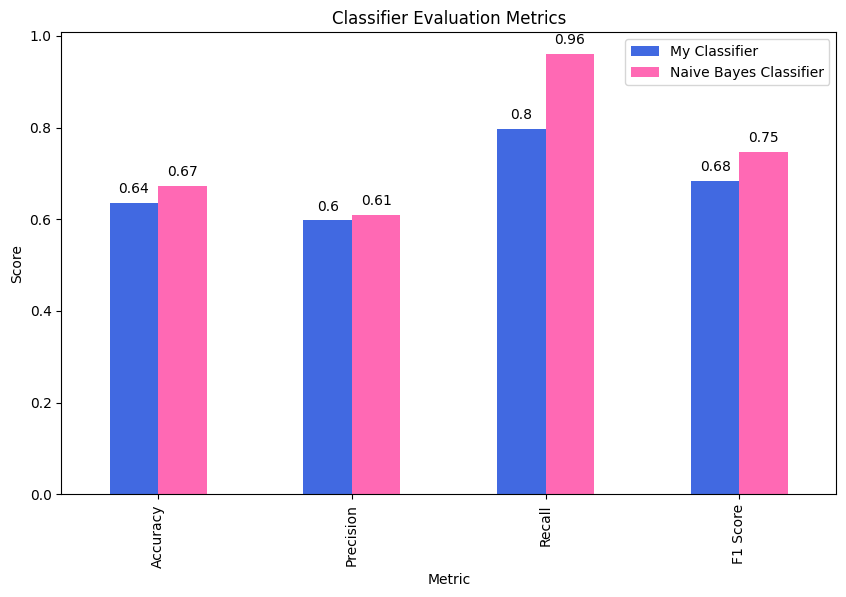

In [23]:
# Add the "Metric" column to the DataFrame
df["Metric"] = ["Accuracy", "Precision", "Recall", "F1 Score"]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
df.set_index("Metric").plot(kind="bar", ax=ax, color=['royalblue', 'hotpink'])
ax.set_ylabel("Score")
ax.set_title("Classifier Evaluation Metrics")

# Display the values on top of the bars
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

The Naive Bayes classifier is more accurate than our worldlist classifier, with a difference of about 0.03. It also has slightly higher precision, although the two values are very close with a difference of only about 0.01. The Naive Bayes classifier outperforms our wordlist classifier most significantly in the recall metric, with a difference of about 0.16. While the Naive Bayes classifier does a better job of correctly identifying positive instances, the two classifiers are comparable in their ability to minimize false positives. As the Naive Bayes classifier outperforms our wordlist classifier in both precision and recall, it follows that it also has a superior F1 Score, with a difference of about 0.07. On all recorded metrics, the Naive Bayes classifier outperforms our wordlist classifier, and so we can conclude that it is better at sentiment analysis on the test set.

In order to improve the performance of our wordlist classifier we could attempt to increase the number of words on the wordlist. We will discuss this potential further in Q5.

#5) [25\%]

In this experiment, we aim to investigate the impact of varying word list sizes on the performance of the word list classifier. The experiment involves iterating over different word list sizes, training a word list classifier with the specified size, and evaluating its accuracy, precision, recall, and F1 score. The experiment is repeated for three runs to ensure robustness. We then evaluate the results of the experiment and draw conclusions.

## Setting Up the Experiment

Below, we try to get a sense of our data to choose appropriate parameters, initialise relevant dictionaries, and set the number of runs and wordlist sizes.

5.1) Examining the order of magnitude for the number of words that contribute significantly to the positive or negative sentiment of the data. We do this to get a sense of how long the wordlists we test in the experiment should be.

In [24]:
values = [0, 1, 2, 5, 10, 15, 20, 50, 75, 100]
pos_diff_dict = {}

difference = pos_freq_dist - neg_freq_dist
sorteddiff = difference.most_common()

for v in values:
  pos_diff_dict[v] = [(word,value) for (word, value) in sorteddiff if value > v]

for v in values:
  print(f"There are {len(pos_diff_dict[v])} noteworthy positive words whose difference is more than {v}")

There are 15240 noteworthy positive words whose difference is more than 0
There are 7905 noteworthy positive words whose difference is more than 1
There are 5341 noteworthy positive words whose difference is more than 2
There are 2722 noteworthy positive words whose difference is more than 5
There are 1419 noteworthy positive words whose difference is more than 10
There are 891 noteworthy positive words whose difference is more than 15
There are 620 noteworthy positive words whose difference is more than 20
There are 139 noteworthy positive words whose difference is more than 50
There are 65 noteworthy positive words whose difference is more than 75
There are 35 noteworthy positive words whose difference is more than 100


In [25]:
neg_diff_dict = {}

difference2 = neg_freq_dist - pos_freq_dist
sorteddiff2 = difference2.most_common()

for v in values:
  neg_diff_dict[v] = [(word,value) for (word, value) in sorteddiff2 if value > v]

for v in values:
  print(f"There are {len(neg_diff_dict[v])} noteworthy negative words whose difference is more than {v}")

There are 11779 noteworthy negative words whose difference is more than 0
There are 5529 noteworthy negative words whose difference is more than 1
There are 3500 noteworthy negative words whose difference is more than 2
There are 1561 noteworthy negative words whose difference is more than 5
There are 722 noteworthy negative words whose difference is more than 10
There are 449 noteworthy negative words whose difference is more than 15
There are 286 noteworthy negative words whose difference is more than 20
There are 58 noteworthy negative words whose difference is more than 50
There are 27 noteworthy negative words whose difference is more than 75
There are 16 noteworthy negative words whose difference is more than 100


5.2) Initialising dictionaries to store accuracy, precision, recall, and F1-scores for different wordlist sizes. These dictionaries will be populated during the experiment, capturing performance metrics for each size wordlist. For each dictionary, the key is the size of the wordlist, and the corresponding value is a list where each item is the metric produced in a run.

In [26]:
# Initialising empty dictionaries to store metric values
accuracy2 = {}
precision = {}
recall = {}
f1 = {}

5.3) Setting `number_of_runs` and `word_list_size`.

We conduct the experiment for 3 runs, and consider wordlist sizes ranging from 2 to 1000.

We set the wordlist sizes no higher than 1000 because we saw in our earlier exploration that setting the wordlist sizes greater than 1000 would capture words below an appropriate threshold of relevancy. We set the number of runs no higher than 3 so that computing cost and processing time do not become unreasonable, as both increase with number of runs.

In [27]:
# Defining number_of_runs and word_list_size
number_of_runs = 3
word_list_size = [2,5,10,20,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500,750,1000]

## Running the Experiment
Below, for each run, we generate training and testing datasets, then train and evaluate the classifier for different wordlist sizes and record the metrics.

5.4) **Iterating Over Runs:** First we create a for loop that encapsulates the entire experiment to run the experiment three times. Multiple runs ensure the robustness of the experiment by smoothing out observations due to random chance.

5.5) **Splitting Data into Training and Testing Sets:** We use the `get_train_test_data()` function to produce training and testing datasets of appropriate proportions.

5.6) **Creating Frequency Distributions:** We create `training_n` and `testing_n`, which modify the training and testing datasets by normalising the wordlists and turning them into frequency distributions, while maintaining the appropriate label for each We then consolodate words from reviews listed as positive or negative into a single frequency distribution for each sentiment.

5.7) **Creating Wordlists & Training Classifiers:** For each size, we run the `most_frequent_words()` function on the positive and negative frequency distributions and select the top *size* words. Then we train a simple classifer using these wordlists.

5.8) **Evaluating the Classifiers:** Using the testing data, we evaluate the accuracy of each classifier and store the value in the dictionary. Additionally, we compute precision, recall, and F1-score using a confusion matrix, and store those values in the relevant dictionaries.

In [28]:
# Iterating Over Runs and Splitting Data into Training and Testing Sets
for i in range(number_of_runs):
    training, testing = get_train_test_data()

    # Creating Frequency Distributions for both datasets
    training_n = [(FreqDist(normalise(wordlist)), label) for (wordlist, label) in training]
    testing_n = [(FreqDist(normalise(wordlist)), label) for (wordlist, label) in testing]

    # Sorting the data in training_norm into a positive and a negative frequency distribution
    pos_fd = FreqDist()
    neg_fd = FreqDist()

    for reviewDist, label in training_n:
        if label == 'pos':
            pos_fd += reviewDist
        else:
            neg_fd += reviewDist

    # Creating Wordlists & Training Classifiers
    for size in word_list_size:
        pos_wordlist = most_frequent_words(pos_fd, neg_fd, size)
        neg_wordlist = most_frequent_words(neg_fd, pos_fd, size)

        clf = SimpleClassifier(pos_wordlist, neg_wordlist)

        acc = classifier_accuracy(clf, testing_n)

        docs,labels=zip(*testing_n)
        sent = ConfusionMatrix(clf.classify_many(docs),labels)

        prec = sent.precision()
        rec = sent.recall()
        f1_score = sent.f1()

        # Store the accuracy value for each size in the dictionary
        if size not in accuracy2:
            accuracy2[size] = []
        accuracy2[size].append(acc)

        # Store the precision value for each size in the dictionary
        if size not in precision:
            precision[size] = []
        precision[size].append(prec)

        # Store the recall value for each size in the dictionary
        if size not in recall:
            recall[size] = []
        recall[size].append(rec)

        # Store the F1 value for each size in the dictionary
        if size not in f1:
            f1[size] = []
        f1[size].append(f1_score)

5.9) Calculating the average accuracy, precision, recall, and F1-score for each word list size.

In [29]:
# Calculate the average accuracy for each size
average_accuracy = {size: sum(acc_list) / len(acc_list) for size, acc_list in accuracy2.items()}

# Calculate the average precision for each size
average_precision = {size: sum(p_list) / len(p_list) for size, p_list in precision.items()}

# Calculate the average recall for each size
average_recall = {size: sum(r_list) / len(r_list) for size, r_list in recall.items()}

# Calculate the average F1 for each size
average_f1 = {size: sum(f1_list) / len(f1_list) for size, f1_list in f1.items()}

## Presenting and Evaluating Experimental Results

5.10) Creating dataframes to store average accuracy, precision, recall, and F1 score value for different word list sizes. We do this for ease of comparison and presentation, and to more easily plot the data later in analysis.

In [30]:
# Create a DataFrame from the average accuracy values
df_a = pd.DataFrame(list(average_accuracy.items()), columns=['Size', 'Accuracy'])
df_a.set_index('Size', inplace=True)

print(df_a)

# Create a DataFrame from the average precision values
df_p = pd.DataFrame(list(average_precision.items()), columns=['Size', 'Precision'])
df_p.set_index('Size', inplace=True)

print(df_p)

# Create a DataFrame from the average recall values
df_r = pd.DataFrame(list(average_recall.items()), columns=['Size', 'Recall'])
df_r.set_index('Size', inplace=True)

print(df_r)

# Create a DataFrame from the average F1 values
df_f1 = pd.DataFrame(list(average_f1.items()), columns=['Size', 'F1 Score'])
df_f1.set_index('Size', inplace=True)

print(df_f1)

      Accuracy
Size          
2     0.573889
5     0.578333
10    0.606111
20    0.608333
50    0.605556
75    0.610556
100   0.603333
125   0.604444
150   0.598333
175   0.591111
200   0.604444
225   0.599444
250   0.596111
275   0.596111
300   0.595000
325   0.591111
350   0.588889
375   0.591111
400   0.592222
425   0.589444
450   0.590000
475   0.590556
500   0.588333
750   0.589444
1000  0.583333
      Precision
Size           
2      0.559591
5      0.555836
10     0.578075
20     0.567346
50     0.559652
75     0.566224
100    0.561296
125    0.561668
150    0.555535
175    0.552011
200    0.561673
225    0.558544
250    0.556338
275    0.553658
300    0.553538
325    0.550326
350    0.550655
375    0.550661
400    0.551021
425    0.550427
450    0.548860
475    0.550801
500    0.551069
750    0.550586
1000   0.547450
        Recall
Size          
2     0.725556
5     0.805556
10    0.815556
20    0.914444
50    0.954444
75    0.950000
100   0.963333
125   0.963333
150   0.96888

5.11) Combining dataframes to present accuracy and F1-score for each size. We focus on these metrics both precision and recall are already accounted for in the F1-Score.

In [31]:
# Merge DataFrames on 'Size'
df_a_f1 = pd.merge(df_a, df_f1, on='Size', how='inner')

print(df_a_f1)

      Accuracy  F1 Score
Size                    
2     0.573889  0.631848
5     0.578333  0.657607
10    0.606111  0.675795
20    0.608333  0.699976
50    0.605556  0.705560
75    0.610556  0.709518
100   0.603333  0.709229
125   0.604444  0.709533
150   0.598333  0.706125
175   0.591111  0.704064
200   0.604444  0.712271
225   0.599444  0.709441
250   0.596111  0.707951
275   0.596111  0.706654
300   0.595000  0.707126
325   0.591111  0.704804
350   0.588889  0.705352
375   0.591111  0.705075
400   0.592222  0.705106
425   0.589444  0.704055
450   0.590000  0.703638
475   0.590556  0.705792
500   0.588333  0.706308
750   0.589444  0.705300
1000  0.583333  0.703012


5.12) Visualising experimental results. Here we plot the `df_a_f` dataframe so that we can visually compare and interpret values for accuracy and F1-score.

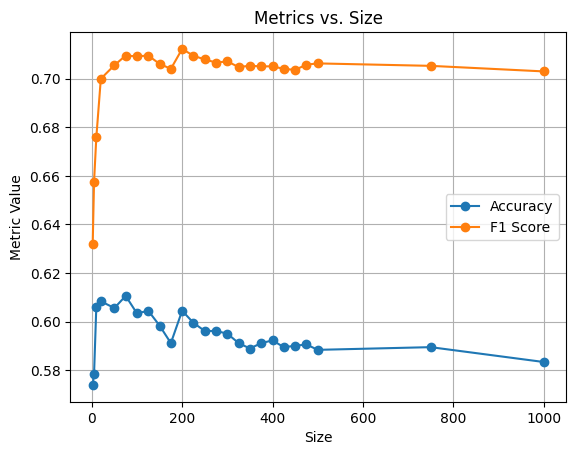

In [32]:
df_a_f1.plot(marker='o', linestyle='-')
plt.title('Metrics vs. Size')
plt.xlabel('Size')
plt.ylabel('Metric Value')
plt.grid(True)
plt.legend(["Accuracy", "F1 Score"])
plt.show()

**Discussion of Trends**

Accuracy jumps up sharply between sizes 5 and 10, and reaches the global maxima at 75, after which it declines until it reaches a local maxima at 175. At 200, we arrive at a local maxima, although the accuracy here is not as high as it was even at size 10. After 200, the accuracy of the classifier declines gently as wordlist size increases.

As wordlist size increases, so does the F1-score of the classifier, which reaches its first peak around 75 and then plateaus. F1-score then decreases after 125, reaching a local minima at 175. The global maximum is at 200, after which the F1-score appears to gently decline as wordlist size increases.

I anticipate that this is because after a certain point, as wordlist size increases, the marginal impact of each new word decreaes and even becomes negative, as a certain threshold of relevancy has been surpassed.Longer wordlists could also overfit the classifier to the training data, which doesn't tell us as much about the testing data or other future datasets we may want to use the classifier on.

**Optimal Sizes**

In attempting to both maximize and balance betwen Accuracy and F1-Score, the wordlist sizes of $75$ and $200$ both seem to be optimal depending on which performance metrics you want to prioritize for a given task. There are only very slight differences between performance of the two.

- $Size = 75$ is the global maxima for the Accuracy plot, and there is a local maxima at this size for the F1-Score plot. When $Size = 75$, $Accuracy = 0.610556$ and $F1 Score = 0.709518$

- $Size = 200$ is the global maxima for the F1-Score plot, and there is a local maxima at this size for the Accuracy plot. When $Size = 75$, $Accuracy = 0.604444$ and $F1 Score = 0.712271$

  

### Comparing the Optimal Wordlist Classifiers and the NLTK Naive Bayes Classifier

Below, we construct a dataframe of relevant metrics and graphically compare the performance of the optimal wordlist classifiers and the NLTK Naive Bayes classifier.

5.13) Creating a dataframe comparing the 75-Word Classifier, the 200-Word Classifier, andn the Naive Bayes Classifier, `df_comparision`.

In [33]:
# Extract metrics for size = 75
size_75_accuracy = average_accuracy.get(75, 0)
size_75_precision = average_precision.get(75, 0)
size_75_recall = average_recall.get(75, 0)
size_75_f1_score = average_f1.get(75, 0)

# Extract metrics for size = 200
size_200_accuracy = average_accuracy.get(200, 0)
size_200_precision = average_precision.get(200, 0)
size_200_recall = average_recall.get(200, 0)
size_200_f1_score = average_f1.get(200, 0)

# Create a DataFrame for the three classifiers
data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "75-Word Classifier": [size_75_accuracy, size_75_precision, size_75_recall, size_75_f1_score],
    "Naive Bayes Classifier": [naive_bayes_accuracy, naive_bayes_precision, naive_bayes_recall, naive_bayes_f1_score],
    "200-Word Classifier": [size_200_accuracy, size_200_precision, size_200_recall, size_200_f1_score]
}

df_comparison = pd.DataFrame(data)

# Print the DataFrame
print(df_comparison)

      Metric  75-Word Classifier  Naive Bayes Classifier  200-Word Classifier
0   Accuracy            0.610556                0.673333             0.604444
1  Precision            0.566224                0.610169             0.561673
2     Recall            0.950000                0.960000             0.973333
3   F1 Score            0.709518                0.746114             0.712271


5.14) Graphically showing the values in `df_comparision` using bar charts.

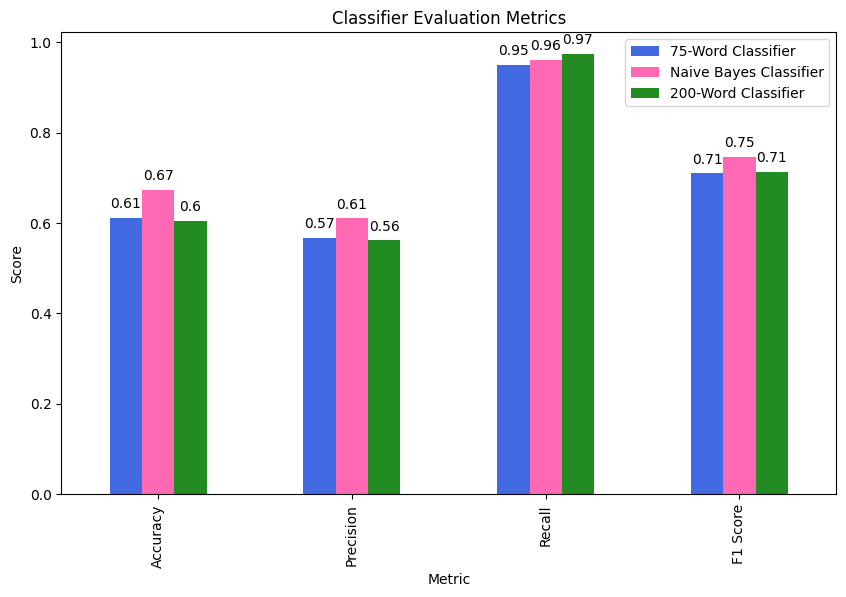

In [34]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
df_comparison.set_index("Metric").plot(kind="bar", ax=ax, color=['royalblue', 'hotpink', 'forestgreen'])
ax.set_ylabel("Score")
ax.set_title("Classifier Evaluation Metrics")

# Display the values on top of the bars
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

***As demonstrated in the graph above, the Naive Bayes classifier consistently outperforms even the most optimal-length wordlist classifier on most relevant metrics, so I would recommend a Naive Bayes classifier for future work in this area.***

The only metric in which a wordlist classifier outperforms the Naive Bayes classifier is in Recall, and this difference is only about 0.02. Although the 200-Word classifier is marginally better at minimizing false negatives than the Naive Bayes classifier, in all other metrics it falls short when the two are compared, and the 75-Word classifier is not even as good as the Naive Bayes classifer in this metric. As such, for most purposes, the Naive Bayes classifier comes out on top as the strongest classifier in this experiment.

### Appendix: Additional Graphs

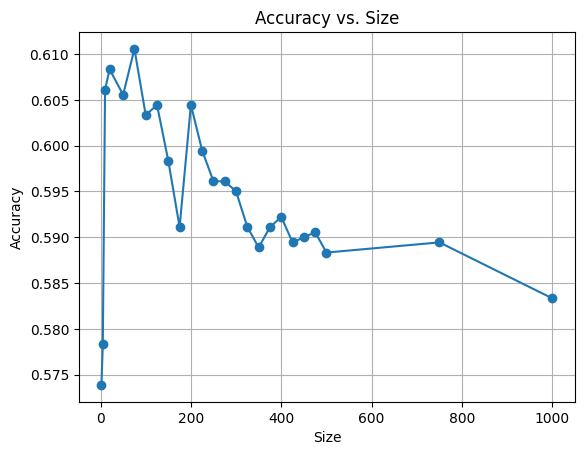

In [35]:
# Convert the dictionary to lists for plotting
sizes = list(average_accuracy.keys())
accuracies = list(average_accuracy.values())

# Plotting
plt.plot(sizes, accuracies, marker='o', linestyle='-')
plt.title('Accuracy vs. Size')
plt.xlabel('Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


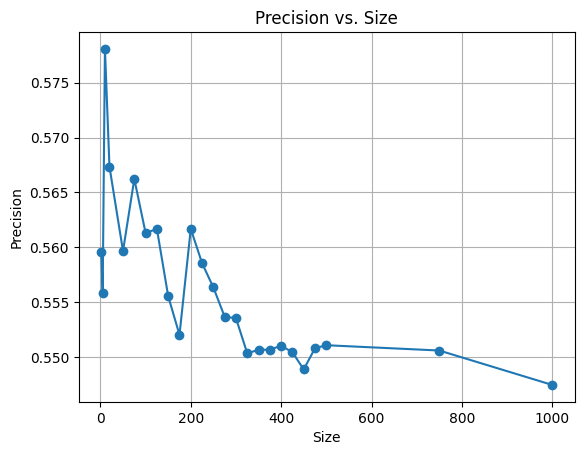

In [36]:
# Convert the dictionary to lists for plotting
sizes = list(average_precision.keys())
precisions = list(average_precision.values())

# Plotting
plt.plot(sizes, precisions, marker='o', linestyle='-')
plt.title('Precision vs. Size')
plt.xlabel('Size')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

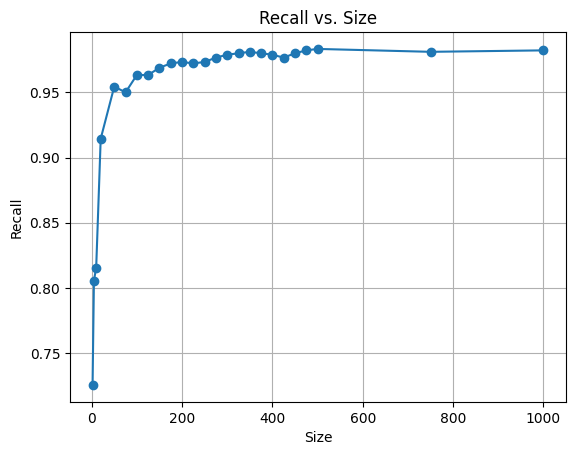

In [37]:
# Convert the dictionary to lists for plotting
sizes = list(average_recall.keys())
recalls = list(average_recall.values())

# Plotting
plt.plot(sizes, recalls, marker='o', linestyle='-')
plt.title('Recall vs. Size')
plt.xlabel('Size')
plt.ylabel('Recall')
plt.grid(True)
plt.show()


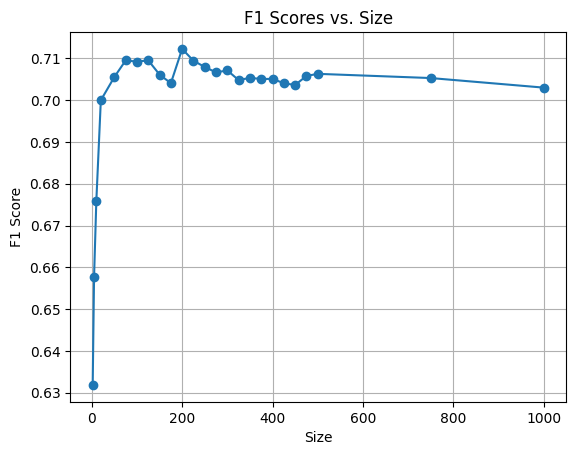

In [38]:
# Convert the dictionary to lists for plotting
sizes = list(average_f1.keys())
f1s = list(average_f1.values())

# Plotting
plt.plot(sizes, f1s, marker='o', linestyle='-')
plt.title('F1 Scores vs. Size')
plt.xlabel('Size')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


# Notebook Word Count

In [39]:
##This code will word count all of the markdown cells in the notebook saved at filepath

import io
from nbformat import current

from google.colab import drive
drive.mount('/content/drive')

filepath="/content/drive/MyDrive/Semester I/Applied Natural Language Processing/Report T1 Week 7/ANLPassignment2023.ipynb"
question_count=432

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

<ipython-input-39-2d5c7e7b4a39>:4: DeprecationWarning: nbformat.current is deprecated since before nbformat 3.0

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  from nbformat import current


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Submission length is 1992
